<a target="_blank" href="https://colab.research.google.com/github/lukebarousse/Python_Data_Analytics_Course/blob/main/3_Project/5_Optimal_Skills.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# What is the most optimal skill to learn for Data Analysts?

#### Methodology

1. Continue from last notebook to find percent of postings with skill
2. Visualize median salary vs percent skill demand
3. (Optional) Determine if certain technologies are more prevalent

#### Original Exploration

[15_Matplotlib_Scatter_Plots.ipynb](../2_Advanced/15_Matplotlib_Scatter_Plots.ipynb)  
[16_Matplotlib_Advanced_Customization.ipynb](../2_Advanced/16_Matplotlib_Advanced_Customization.ipynb)

## Import Libraries and Data

Import the libraries, data and change the `job_posted_date` to a datetime type.

In [21]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt


# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)


## Clean Data

Filters the original dataset to only get rows where the job title is 'Data Analyst' and the country is 'United States', to create a new DataFrame `df_DA_CA`. Drop NaN values from the 'salary_year_avg' column. Then it uses the `explode` method on the `job_skills` column to create a new row in a new DataFrame (`df_DA_CA_exploded`) for each skill associated with a job. Finally, it displays the first 5 entries of the `salary_year_avg` and `job_skills` columns.

In [31]:
df_DA_CA = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'Canada')].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_CA = df_DA_CA.dropna(subset=['salary_year_avg'])

df_DA_CA_exploded = df_DA_CA.explode('job_skills')

df_DA_CA_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
48811,105000.0,sql
48811,105000.0,python
48811,105000.0,javascript
48811,105000.0,bigquery
48811,105000.0,tableau


## Calculate Percent of Job Postings that Have Skills

Group the data by job skills and calculates the count and median salary for each skill, sorting the results in descending order by count. It then renames the columns. Calculates the percentage that each skill count represents out of the total number of Data Analyst jobs. Finally, filter out any skills that don't have any jobs associated with them.

In [33]:
# using df_DA find the count of skills and also the median salary for each skill
df_DA_skills = df_DA_CA_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_CA)  # Find count of Data Analyst jobs in Canada with salary info

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,17,99150.00,54.838710
python,14,99825.00,45.161290
tableau,10,98825.00,32.258065
excel,9,98500.00,29.032258
sas,8,98500.00,25.806452
power bi,5,75000.00,16.129032
vba,4,84500.00,12.903226
sheets,4,99500.00,12.903226
spark,4,109795.25,12.903226


## Median Salary vs Percent Skill Demand

Filters for Data Analyst skills that exceed a certain percentage (`skill_limit`).

In [35]:
skill_limit = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

Create a scatter plot to visualize the relationship between the percentage of Data Analyst jobs that require specific skills and the median salary for those skills.

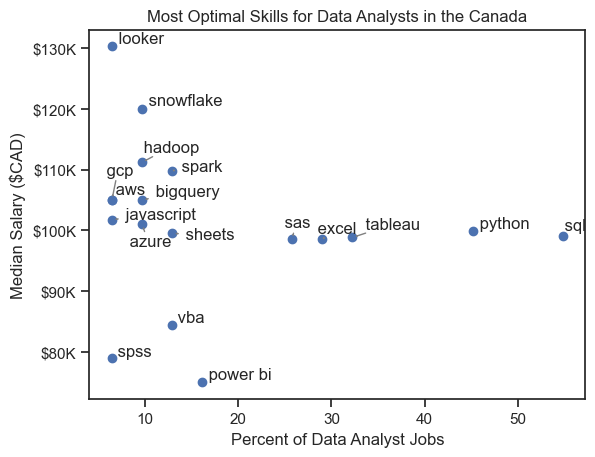

In [36]:
from adjustText import adjust_text

plt.scatter(df_DA_skills_high_demand['skill_percent'], df_DA_skills_high_demand['median_salary'])
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Salary ($CAD)')  # Assuming this is the label you want for y-axis
plt.title('Most Optimal Skills for Data Analysts in the Canada')

# Get current axes(gca), set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))  # Example formatting y-axis

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], " " + txt))

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

## Bonus: Coloring by Technology

We're going to add color labels based on technology.

Removes duplicate entries and any rows with missing values. Then, it combines all dictionary entries into a single dictionary, summing values for keys that repeat across entries. To ensure each key's values are unique, it converts the values to a set and then back to a list. The final result is a dictionary where each key represents a skill and each value is a list of unique attributes associated with that skill.

In [37]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['microstrategy',
  'alteryx',
  'ms access',
  'sap',
  'tableau',
  'looker',
  'powerbi',
  'sheets',
  'sas',
  'excel',
  'spss',
  'power bi',
  'nuix',
  'sharepoint',
  'visio',
  'spreadsheet',
  'esquisse',
  'splunk',
  'dax',
  'datarobot',
  'ssrs',
  'qlik',
  'powerpoint',
  'word',
  'msaccess',
  'cognos',
  'outlook',
  'ssis'],
 'programming': ['c#',
  'java',
  'julia',
  'fortran',
  'apl',
  'swift',
  'sql',
  'elixir',
  'golang',
  'python',
  'matlab',
  'bash',
  'sass',
  'scala',
  'crystal',
  'vb.net',
  'clojure',
  'ruby',
  'perl',
  'solidity',
  'typescript',
  'sas',
  'ocaml',
  'r',
  'mongodb',
  'objective-c',
  'vba',
  'haskell',
  'lua',
  'lisp',
  'javascript',
  'php',
  'c++',
  'shell',
  'pascal',
  't-sql',
  'nosql',
  'no-sql',
  'erlang',
  'kotlin',
  'css',
  'groovy',
  'dart',
  'delphi',
  'visualbasic',
  'go',
  'powershell',
  'mongo',
  'c',
  'rust',
  'cobol',
  'visual basic',
  'f#',
  'assembly',
  'h

This code converts a dictionary into a pandas DataFrame, then explodes the 'skills' column, creating multiple rows for each 'technology' entry if it contains multiple skills.

In [38]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology


,technology,skills
0,analyst_tools,microstrategy
0,analyst_tools,alteryx
0,analyst_tools,ms access
0,analyst_tools,sap
0,analyst_tools,tableau
...,...,...
9,sync,mattermost
9,sync,rocketchat
9,sync,ringcentral
9,sync,zoom


Merges two DataFrames, `df_DA_skills` and `df_technology`, based on the columns 'job_skills' and 'skills' respectively, creating a new DataFrame `df_DA_skills_tech`.

In [39]:
# merge df_DA_skills and df_technology
df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percent,technology,skills
0,17,99150.00,54.838710,programming,sql
1,14,99825.00,45.161290,programming,python
2,10,98825.00,32.258065,analyst_tools,tableau
3,9,98500.00,29.032258,analyst_tools,excel
4,8,98500.00,25.806452,analyst_tools,sas
5,8,98500.00,25.806452,programming,sas
6,5,75000.00,16.129032,analyst_tools,power bi
7,4,84500.00,12.903226,programming,vba
8,4,99500.00,12.903226,analyst_tools,sheets
9,4,109795.25,12.903226,libraries,spark


Filters `df_DA_skills_tech` to select rows where the 'percent' column exceeds a specified threshold, storing the result in `df_DA_skills_tech_high_demand`.

In [40]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]

Plot the results in a scatter plot, coloring the points based on the 'technology' column.

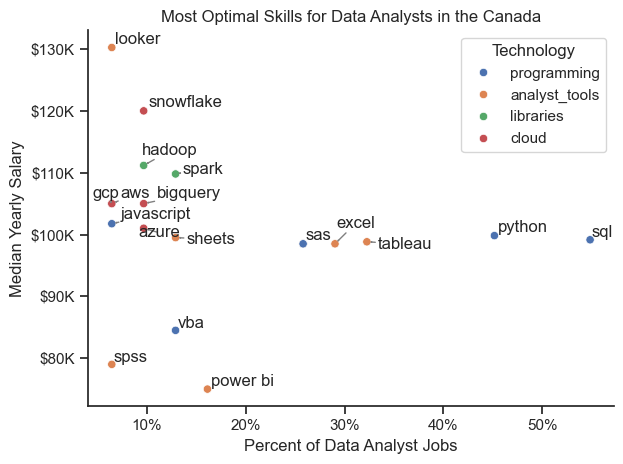

In [41]:
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the Canada')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot
plt.tight_layout()
plt.show()
